In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from rmsd_predictor_evaluator import RMSDPredictorEvaluator

In [19]:
evaluator = RMSDPredictorEvaluator(model=None, 
                                   evaluation_name='random_split_0_pdbbind')

In [20]:
evaluator.load_existing_results()

In [21]:
mol_results = evaluator.mol_results
included_smiles = evaluator.get_included_smiles()

In [22]:
splits = ['random', 'scaffold', 'protein', 'ecfp']
iterations = range(5)

In [23]:
def get_model_name(split) :
    d = {'random' : 'BioSchNet (random split)',
        'scaffold' : 'BioSchNet (scaffold split)',
        'protein' : 'BioSchNet (protein split)',
        'ecfp' : 'BioSchNet (ECFP split)'}
    return d[split]

In [24]:
def get_baseline_name(ranker) :
    d = {'random' : 'Random',
        'ccdc' : 'CCDC',
        'energy' : 'UFF energy'}
    return d[ranker]

In [25]:
def get_ranker_name(ranker) :
    d = {'random' : 'Random',
        'ccdc' : 'CCDC',
        'energy' : 'UFF energy',
        'model' : 'BioSchNet'}
    return d[ranker]

In [26]:
def custom_agg(series) :
    result = ''
    
    mean = series.mean()
    if not np.isnan(mean) :
        result = result + str(mean.round(2))
        
    std = series.std().round(2)
    if not np.isnan(std) :
        result = result + ' ± ' + str(std.round(2))
    
    if result == '' :
        result = 'NA'
    return result

In [27]:
rank_name = 'normalized_first_bioactive_like_rank'
ylabel = 'Normalized rank of bioactive-like'
active_ratio_threshold = 0.05
df = pd.DataFrame()
for split in splits :
    for iteration in iterations :
        evaluator = RMSDPredictorEvaluator(model=None, 
                                   evaluation_name=f'{split}_split_{iteration}_pdbbind')
        evaluator.load_existing_results()
        mol_results = evaluator.mol_results
        included_smiles = evaluator.get_included_smiles()
        for smiles, res in mol_results.items() :
            if smiles in included_smiles :
                if rank_name in res :
                    n_actives = res['n_actives']
                    n_generated = res['n_generated']
                    active_ratio = n_actives / n_generated
                    if active_ratio <= active_ratio_threshold :
                        for ranker, rank in res[rank_name].items() :
                            ranker = get_ranker_name(ranker)
                            df = df.append({'Ranker' : ranker, 
                                            ylabel : rank,
                                            'First bioactive' : rank == 0,
                                            'Iteration' : iteration,
                                            'Split' : split}, ignore_index=True)

In [28]:
grouped_data = df.groupby(['Split', 'Ranker', 'Iteration'], sort=False).agg({'First bioactive' : np.mean, ylabel : np.median})
ylabel_rank = 'Median normalized rank of bioactive-like'
ylabel_fraction = 'Fraction of bioactive-like ranked first'
grouped_data = grouped_data.rename({'First bioactive' : ylabel_fraction, ylabel : ylabel_rank}, axis=1)
grouped_data = grouped_data.groupby(['Split', 'Ranker'], sort=False).agg({ylabel_fraction : custom_agg, ylabel_rank : custom_agg})
grouped_data = grouped_data.unstack(1)
grouped_data.index.name = 'Split'
grouped_data.columns.names = [None, 'Ranker']
grouped_data = grouped_data.rename({name : name.capitalize() for name in grouped_data.index})
grouped_data

Fraction of bioactive-like ranked first                            \
Ranker                                 BioSchNet         CCDC   UFF energy   
Split                                                                        
Random                               0.14 ± 0.01  0.03 ± 0.01  0.05 ± 0.02   
Scaffold                             0.14 ± 0.02  0.03 ± 0.01  0.04 ± 0.02   
Protein                              0.06 ± 0.01  0.03 ± 0.01  0.05 ± 0.01   
Ecfp                                  0.1 ± 0.03  0.02 ± 0.01  0.05 ± 0.01   

                      Median normalized rank of bioactive-like               \
Ranker         Random                                BioSchNet         CCDC   
Split                                                                         
Random    0.03 ± 0.01                              0.09 ± 0.02  0.29 ± 0.02   
Scaffold  0.03 ± 0.02                              0.11 ± 0.02  0.29 ± 0.03   
Protein   0.03 ± 0.01                              0.19 ± 0.03  0.27 ± 0.04   
Ecfp      0.03 ± 0.01                              0.16 ± 0.02  0.29 ± 0.02   

                                    
Ranker     UFF energy       Random  
Split                               
Random    0.22 ± 0.02  0.25 ± 0.02  
Scaffold  0.21 ± 0.03  0.24 ± 0.02  
Protein   0.22 ± 0.01  0.25 ± 0.04  
Ecfp      0.23 ± 0.03  0.24 ± 0.02

In [29]:
grouped_data = df.groupby(['Split', 'Ranker', 'Iteration'], sort=False).agg({ylabel : np.median})
ylabel_rank = 'Median normalized rank of bioactive-like'
grouped_data = grouped_data.rename({'First bioactive' : ylabel_fraction, ylabel : ylabel_rank}, axis=1)
grouped_data = grouped_data.groupby(['Split', 'Ranker'], sort=False).agg({ylabel_rank : custom_agg})
grouped_data = grouped_data.unstack(1)
grouped_data.index.name = 'Split'
grouped_data.columns.names = [None, 'Ranker']
grouped_data = grouped_data.rename({name : name.capitalize() for name in grouped_data.index})
grouped_data

Median normalized rank of bioactive-like                            \
Ranker                                  BioSchNet         CCDC   UFF energy   
Split                                                                         
Random                                0.09 ± 0.02  0.29 ± 0.02  0.22 ± 0.02   
Scaffold                              0.11 ± 0.02  0.29 ± 0.03  0.21 ± 0.03   
Protein                               0.19 ± 0.03  0.27 ± 0.04  0.22 ± 0.01   
Ecfp                                  0.16 ± 0.02  0.29 ± 0.02  0.23 ± 0.03   

                       
Ranker         Random  
Split                  
Random    0.25 ± 0.02  
Scaffold  0.24 ± 0.02  
Protein   0.25 ± 0.04  
Ecfp      0.24 ± 0.02

In [30]:
grouped_data = df.groupby(['Split', 'Ranker', 'Iteration'], sort=False).agg({'First bioactive' : np.mean})
ylabel_fraction = 'Fraction of bioactive-like ranked first'
grouped_data = grouped_data.rename({'First bioactive' : ylabel_fraction, ylabel : ylabel_rank}, axis=1)
grouped_data = grouped_data.groupby(['Split', 'Ranker'], sort=False).agg({ylabel_fraction : custom_agg})
grouped_data = grouped_data.unstack(1)
grouped_data.index.name = 'Split'
grouped_data.columns.names = [None, 'Ranker']
grouped_data = grouped_data.rename({name : name.capitalize() for name in grouped_data.index})
grouped_data

Fraction of bioactive-like ranked first                            \
Ranker                                 BioSchNet         CCDC   UFF energy   
Split                                                                        
Random                               0.14 ± 0.01  0.03 ± 0.01  0.05 ± 0.02   
Scaffold                             0.14 ± 0.02  0.03 ± 0.01  0.04 ± 0.02   
Protein                              0.06 ± 0.01  0.03 ± 0.01  0.05 ± 0.01   
Ecfp                                  0.1 ± 0.03  0.02 ± 0.01  0.05 ± 0.01   

                       
Ranker         Random  
Split                  
Random    0.03 ± 0.01  
Scaffold  0.03 ± 0.02  
Protein   0.03 ± 0.01  
Ecfp      0.03 ± 0.01

In [64]:
def plot_cumulative_bio_like(active_ratio_threshold) :
    rank_name = 'normalized_first_bioactive_like_rank'
    xlabel = 'Normalized rank of bioactive-like'
    ranks = pd.DataFrame()
    for split in splits :
        for iteration in iterations :
            evaluator = RMSDPredictorEvaluator(model=None, 
                                       evaluation_name=f'{split}_split_{iteration}_pdbbind')
            evaluator.load_existing_results()
            mol_results = evaluator.mol_results
            included_smiles = evaluator.get_included_smiles()
            for smiles, res in mol_results.items() :
                if smiles in included_smiles :
                    if rank_name in res :
                        n_actives = res['n_actives']
                        n_generated = res['n_generated']
                        active_ratio = n_actives / n_generated
                        if active_ratio <= active_ratio_threshold :
                            for ranker, rank in res[rank_name].items() :
                                if ranker == 'model' :
                                    ranker = get_model_name(split)
                                else :
                                    ranker = get_baseline_name(ranker)
                                ranks = ranks.append({'Ranker' : ranker, 
                                                      xlabel : rank,
                                                     'Iteration' : iteration}, ignore_index=True)
    
    xlabel2 = 'Percentage of ranked generated conformations'
    ranks[xlabel2] = ranks[xlabel] * 99 + 1
    
    hue_order = ['Random', 
                 'UFF energy', 
                 'CCDC', 
                 'BioSchNet (random split)', 
                 'BioSchNet (scaffold split)', 
                 'BioSchNet (protein split)',]
                 #'BioSchNet (ECFP split)']
    with sns.plotting_context('talk', font_scale=0.7) :
        sns.ecdfplot(data=ranks, x=xlabel2, hue='Ranker', hue_order=hue_order)
        plt.xlim(0, 101)
        plt.ylim(0, 1.02)
        plt.ylabel('Proportion of molecules with\nbioactive-like retrieved')
        plt.tight_layout()
        plt.savefig(f'figures/bioactive_like_ranks_{active_ratio_threshold}.png', dpi=300)
        plt.show()

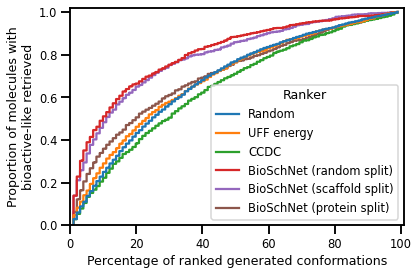

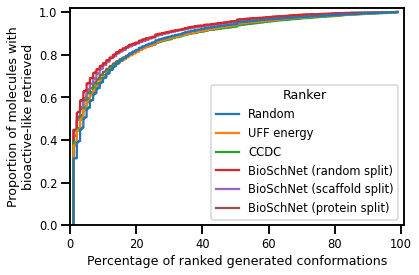

In [65]:
for threshold in [0.05, 1] :
    plot_cumulative_bio_like(active_ratio_threshold=threshold)

In [46]:
rank_name = 'normalized_first_bioactive_like_rank'
ylabel = 'Normalized rank of bioactive-like'
active_ratio_threshold = 1
ranks = pd.DataFrame()
for split in splits :
    for iteration in iterations :
        evaluator = RMSDPredictorEvaluator(model=None, 
                                   evaluation_name=f'{split}_split_{iteration}_pdbbind')
        evaluator.load_existing_results()
        mol_results = evaluator.mol_results
        included_smiles = evaluator.get_included_smiles()
        for smiles, res in mol_results.items() :
            if smiles in included_smiles :
                if rank_name in res :
                    n_actives = res['n_actives']
                    n_generated = res['n_generated']
                    active_ratio = n_actives / n_generated
                    if active_ratio <= active_ratio_threshold :
                        for ranker, rank in res[rank_name].items() :
                            if ranker == 'model' :
                                ranker = get_model_name(split)
                            else :
                                ranker = get_baseline_name(ranker)
                            ranks = ranks.append({'Ranker' : ranker, 
                                                  ylabel : rank,
                                                 'Iteration' : iteration}, ignore_index=True)

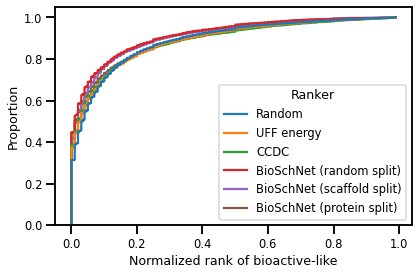

In [47]:
hue_order = ['Random', 
             'UFF energy', 
             'CCDC', 
             'BioSchNet (random split)', 
             'BioSchNet (scaffold split)', 
             'BioSchNet (protein split)',]
             #'BioSchNet (ECFP split)']
with sns.plotting_context('talk', font_scale=0.7) :
    sns.ecdfplot(data=ranks, x=ylabel, hue='Ranker', hue_order=hue_order)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.savefig('figures/bioactive_like_ranks.png', dpi=300)

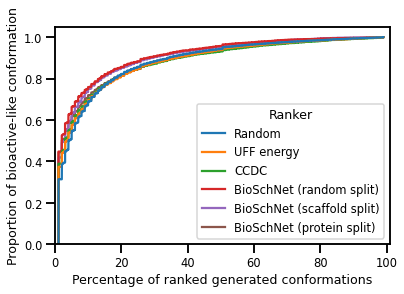

In [48]:
import copy
copy_ranks = copy.deepcopy(ranks)
copy_ranks[ylabel] = copy_ranks[ylabel] * 99 + 1
with sns.plotting_context('talk', font_scale=0.7) :
    sns.ecdfplot(data=copy_ranks, x=ylabel, hue='Ranker', hue_order=hue_order)
    plt.xlim(0, 101)
    plt.ylim(0, 1.05)
    plt.xlabel('Percentage of ranked generated conformations')
    plt.ylabel('Proportion of bioactive-like conformation')
#     plt.tight_layout()
#     plt.savefig('figures/bioactive_like_ranks.png', dpi=300)

In [49]:
rank_name = 'normalized_first_bioactive_like_rank'
ylabel = 'Normalized rank of bioactive-like'
active_ratio_threshold = 0.05
ranks = pd.DataFrame()
for split in splits :
    for iteration in iterations :
        evaluator = RMSDPredictorEvaluator(model=None, 
                                   evaluation_name=f'{split}_split_{iteration}_pdbbind')
        evaluator.load_existing_results()
        mol_results = evaluator.mol_results
        included_smiles = evaluator.get_included_smiles()
        for smiles, res in mol_results.items() :
            if smiles in included_smiles :
                if rank_name in res :
                    n_actives = res['n_actives']
                    n_generated = res['n_generated']
                    active_ratio = n_actives / n_generated
                    if active_ratio <= active_ratio_threshold :
                        for ranker, rank in res[rank_name].items() :
                            if ranker == 'model' :
                                ranker = get_model_name(split)
                            else :
                                ranker = get_baseline_name(ranker)
                            ranks = ranks.append({'Ranker' : ranker, 
                                                  ylabel : rank,
                                                 'Iteration' : iteration}, ignore_index=True)

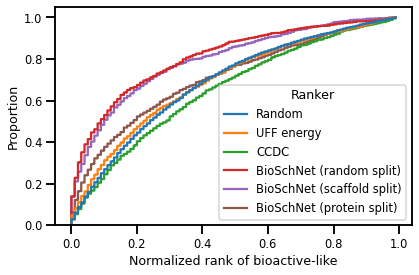

In [50]:
hue_order = ['Random', 
             'UFF energy', 
             'CCDC', 
             'BioSchNet (random split)', 
             'BioSchNet (scaffold split)', 
             'BioSchNet (protein split)']
#              'BioSchNet (ECFP split)']
with sns.plotting_context('talk', font_scale=0.7) :
    sns.ecdfplot(data=ranks, x=ylabel, hue='Ranker', hue_order=hue_order)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.savefig('figures/bioactive_like_ranks.png', dpi=300)

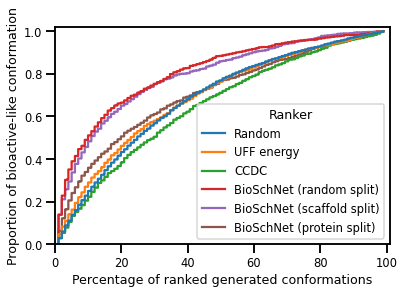

In [52]:
import copy
copy_ranks = copy.deepcopy(ranks)
copy_ranks[ylabel] = copy_ranks[ylabel] * 99 + 1
with sns.plotting_context('talk', font_scale=0.7) :
    sns.ecdfplot(data=copy_ranks, x=ylabel, hue='Ranker', hue_order=hue_order)
    plt.xlim(0, 101)
    plt.ylim(0, 1.02)
    plt.xlabel('Percentage of ranked generated conformations')
    plt.ylabel('Proportion of bioactive-like conformation')
#     plt.tight_layout()
#     plt.savefig('figures/bioactive_like_ranks.png', dpi=300)

In [16]:
rank_name = 'normalized_first_bioactive_rank'
ylabel = 'Normalized rank of bioactive'
ranks = pd.DataFrame()
for split in splits :
    for iteration in iterations :
        evaluator = RMSDPredictorEvaluator(model=None, 
                                   evaluation_name=f'{split}_split_{iteration}_pdbbind')
        evaluator.load_existing_results()
        mol_results = evaluator.mol_results
        included_smiles = evaluator.get_included_smiles()
        for smiles, res in mol_results.items() :
            if smiles in included_smiles :
                if rank_name in res :
                    for ranker, rank in res[rank_name].items() :
                        if ranker == 'model' :
                            ranker = get_model_name(split)
                        else :
                            ranker = get_baseline_name(ranker)
                        ranks = ranks.append({'Ranker' : ranker, 
                                              ylabel : rank,
                                             'Iteration' : iteration}, ignore_index=True)

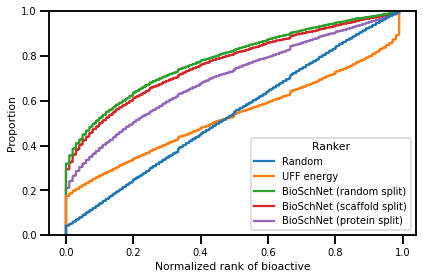

In [17]:
hue_order = ['Random', 
             'UFF energy', 
             'BioSchNet (random split)', 
             'BioSchNet (scaffold split)', 
             'BioSchNet (protein split)']
with sns.plotting_context('talk', font_scale=0.6) :
    sns.ecdfplot(data=ranks, x=ylabel, hue='Ranker', hue_order=hue_order)
    plt.tight_layout()
    plt.savefig('figures/bioactive_ranks.png', dpi=300)